In [1]:
G_path = '/Users/sepehrbe/My_Drive/DataSources/SkinCare'
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
#import torchvision.transforms.Compose
import numpy as np
from CNN_NETs import CNN_Nets 
# from Net8 import Net8_a
from Model_Training import Model_Training_with_loader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader

import time
import os
from usefull_functions import *
from statistics import mean
import pandas as pd
import sklearn as sk
import pickle
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
device = torch.device('cpu')

# **Import DataSets**

In [2]:
file = 'DataSet_280x210' 
input_data , labels = pickle.load(open(G_path + '/DataSet_280x210/'+ file,'rb'))
labels_biary = labels[1]
labels_multi = labels[0]

file = 'Latent_Input_Data_labels' 
A_E_input_data , A_E_labels = pickle.load(open(G_path + '/Augmented_AutoEncoded/'+ file,'rb'))
A_E_labels_biary = A_E_labels[1]
A_E_labels_multi = A_E_labels[0]

file = 'Evaluation_set_280x210' 
BLC_test_280x210 = pickle.load(open(G_path + '/DataSet_280x210/' + file,'rb'))

file = 'Evaluation_set_AutoEncoder' 
BLC_test_A_E = pickle.load(open(G_path + '/Augmented_AutoEncoded/' + file,'rb'))

Meta_Data_Augmented = pickle.load(open( G_path + '/Meta_Data_Augmented','rb'))

# **Import Model**

In [3]:
C_280 = 'CNN_280x210_MultiClassModel0_24_Jun22_22-38' # Best of grid search ['CNN_280x210_Model5_23_Jun22_12-55','CNN_280x210_Model4_22_Jun22_00-14]
C_280_binary = 'CNN_280x210_Binary_24_Jun22_22-17'

Model_280x210_multi = pickle.load(open(G_path + '/Saved/Models/Grid_Search_Models/'+ C_280 , 'rb') ).eval()
Model_280x210_binary = pickle.load(open(G_path + '/Saved/Models/Grid_Search_Models/'+ C_280_binary , 'rb') ).eval()

A_E = 'A_E_CNN_Model6_22_Jun22_00-29' #Best of grid search
A_E_binary = 'A_E_CNN_Model0_25_Jun22_09-35'
# [CNN_Nets.Net8_a, Model_Training_with_loader] = pickle.load(open(G_Models+'/Net8_Model_Trainin','rb'))
Model_A_En_multiclass = pickle.load(open(G_path + '/Saved/Models/Grid_Search_Models/' + A_E , 'rb') ).eval()
Model_A_En_binary = pickle.load(open(G_path + '/Saved/Models/Grid_Search_Models/' + A_E_binary , 'rb') ).eval()

# **Model Evaluation**

Nr. of Data : 
 407
Accuracy of The Model : 
 0.6535626535626535


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,45.2%,60.9%,95.6%,51.9%
1,7.9%,55.0%,68.8%,95.2%,61.1%
2,17.7%,47.9%,62.5%,85.4%,54.2%
3,2.0%,66.7%,50.0%,99.5%,57.1%
4,15.2%,45.2%,53.2%,88.4%,48.9%
5,49.1%,92.7%,69.5%,94.7%,79.4%
6,2.5%,69.2%,90.0%,99.0%,78.3%
Simple Avg.,nan%,60.3%,65.0%,94.0%,61.6%
Weighted Avg.,nan%,70.8%,65.4%,92.4%,66.9%


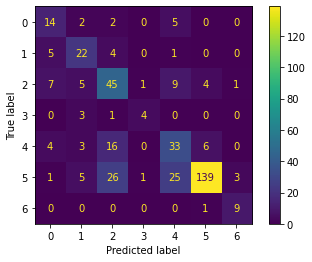

In [4]:
# Model 280x210
binary = False
if binary:
    model_ = Model_280x210_binary
    Y = labels_biary[2]
else:
    model_ = Model_280x210_multi
    Y = labels_multi[2]
X = input_data[2]
# X = BLC_test_280x210[0]
# Y = BLC_test_280x210[1]
iter = X.shape[0] // 100
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*100:(i+1)*100]
    Y_ = model_.forward_noDrop(X_).argmax(dim=1)
    Y_pred = torch.cat([Y_pred,Y_])

Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
# results = model_evaluation(Y_binary,Y_pred_binary)
results = model_evaluation(Y,Y_pred)
results

Nr. of Data : 
 407
Accuracy of The Model : 
 0.7272727272727273


,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,71.3%,89.1%,70.3%,78.6%,78.6%
1,28.7%,51.7%,78.6%,70.3%,62.4%
Simple Avg.,nan%,70.4%,74.5%,74.5%,70.5%
Weighted Avg.,nan%,78.3%,72.7%,76.3%,73.9%


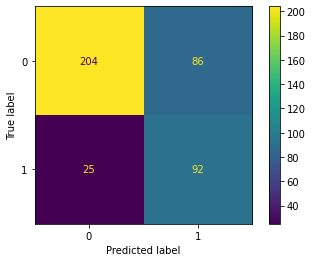

In [18]:
# Model AutoEncoder
binary = False
if binary:
    model_ = Model_A_En_binary
    Y = A_E_labels_biary[2]
else:
    model_ = Model_A_En_multiclass
    Y = A_E_labels_multi[2]
    
X = A_E_input_data[2]
# X = BLC_test_A_E[0]
# Y = BLC_test_A_E[1]
iter = X.shape[0] // 100
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*100:(i+1)*100]
    Y_ = model_.forward_noDrop(X_).argmax(dim=1)
    Y_pred = torch.cat([Y_pred,Y_])
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
# results = model_evaluation(Y,Y_pred)
results = model_evaluation(Y_binary,Y_pred_binary)
results

# **CNN: 280x210 MultiClass: Get CNN OutPut (Soft-Max)**

In [12]:

model_ = Model_280x210
X = torch.cat([input_data[0],input_data[1],input_data[2]],dim=0).detach()
n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n]
    Y_ = torch.softmax(model_.forward_noDrop(X_),dim=1).detach()
    # Y_ = model_.forward_noDrop(X_).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
X.shape , Y_pred.shape

(torch.Size([4647, 3, 280, 210]), torch.Size([4647, 7]))

In [19]:
# X = torch.cat([input_data[0],input_data[1],input_data[2]],dim=0).detach()
# deploy_dataloader = DataLoader(dataset = X, batch_size = 200, num_workers=4 , pin_memory=True , shuffle=False) 

# model_ = Model_280x210
# Y_pred = torch.zeros(0)
# for X_ in deploy_dataloader:
#     Y_ = torch.softmax(model_.forward_noDrop(X_) ,dim=1).detach()
#     Y_pred = torch.cat([Y_,Y_pred]).detach()
# print(X.shape , Y_pred.shape )

In [13]:
df_CNN = pd.DataFrame(Y_pred.detach().numpy()).add_prefix('CNN_')
meta_data_key = pd.concat([input_data[3][0],input_data[3][1],input_data[3][2]],axis=0).reset_index(drop=True)
df_CNN = pd.concat([meta_data_key,df_CNN],axis=1).reset_index(drop=True)
CNN_280x210_data = df_CNN.merge(Meta_Data_Augmented.drop(columns=['type']) ,how='left', on='image_id')

In [14]:
CNN_280x210_data['CNN_0'].max()

0.99732554

In [15]:
cols = ['localization','sex','dx_type']
CNN_280x210_data_encoded = pd.get_dummies(CNN_280x210_data, columns= cols).reset_index(drop=True)
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train')][attr].mean()
    std = dataset[dataset.type.str.contains('train')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset
CNN_280x210_data_encoded_STD = standardizaion(CNN_280x210_data_encoded,'age')

In [16]:
pickle.dump(CNN_280x210_data_encoded_STD, open(G_path + '/CNN_Output/'+ 'CNN_280x210_Ouput_MultiClass', 'wb'))

# **CNN: 280x210 Binary**

In [24]:

model_ = Model_280x210_binary
X = torch.cat([input_data[0],input_data[1],input_data[2]],dim=0).detach()
n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n]
    Y_ = torch.softmax(model_.forward_noDrop(X_),dim=1).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
X.shape , Y_pred.shape

(torch.Size([4647, 3, 280, 210]), torch.Size([4647, 2]))

In [25]:
df_CNN = pd.DataFrame(Y_pred.detach().numpy()).add_prefix('CNN_')
meta_data_key = pd.concat([input_data[3][0],input_data[3][1],input_data[3][2]],axis=0).reset_index(drop=True)
df_CNN = pd.concat([meta_data_key,df_CNN],axis=1).reset_index(drop=True)
CNN_280x210_data_binary = df_CNN.merge(Meta_Data_Augmented.drop(columns=['type']) ,how='left', on='image_id')

In [26]:
CNN_280x210_data_binary[:2]

,type,image_id,CNN_0,CNN_1,lesion_id,dx,dx_type,age,sex,localization,image_label,binary_label
0,train,ISIC_0032929,0.457048,0.542952,HAM_0003321,bkl,histo,75.0,female,face,2,0
1,train,ISIC_0026790,0.875181,0.124819,HAM_0005779,bkl,consensus,55.0,male,back,2,0


In [27]:
cols = ['localization','sex','dx_type']
CNN_280x210_data_binary_encoded = pd.get_dummies(CNN_280x210_data_binary, columns= cols).reset_index(drop=True)
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train')][attr].mean()
    std = dataset[dataset.type.str.contains('train')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset
CNN_280x210_data_binary_encoded_STD = standardizaion(CNN_280x210_data_binary_encoded,'age')

In [28]:
pickle.dump(CNN_280x210_data_binary_encoded_STD, open(G_path + '/CNN_Output/'+ 'CNN_280x210_Ouput_binary', 'wb'))

# **CNN: AutoEncoder, Get CNN OutPut (Soft-Max)**

In [36]:
model_ = Model_A_En_multiclass
X = torch.cat([A_E_input_data[0],A_E_input_data[1],A_E_input_data[2]],dim=0).detach()
n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n]
    Y_ = torch.softmax(model_.forward_noDrop(X_),dim=1).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
X.shape , Y_pred.shape

(torch.Size([4647, 3, 282, 207]), torch.Size([4647, 7]))

In [40]:
df_CNN = pd.DataFrame(Y_pred.detach().numpy()).add_prefix('CNN_')
meta_data_key = pd.concat([A_E_input_data[3][0],A_E_input_data[3][1],A_E_input_data[3][2]],axis=0).reset_index(drop=True)
df_CNN = pd.concat([meta_data_key,df_CNN],axis=1).reset_index(drop=True)
CNN_A_E_data = df_CNN.merge(Meta_Data_Augmented.drop(columns=['type']) ,how='left', on='image_id')

In [41]:
cols = ['localization','sex','dx_type']
CNN_A_E_data_encoded = pd.get_dummies(CNN_A_E_data, columns= cols).reset_index(drop=True)
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train')][attr].mean()
    std = dataset[dataset.type.str.contains('train')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset
CNN_A_E_data_encoded_STD = standardizaion(CNN_A_E_data_encoded,'age')

In [42]:
pickle.dump(CNN_A_E_data_encoded_STD, open(G_path + '/CNN_Output/'+ 'CNN_A_E_Ouput_MultiClass', 'wb'))

# **CNN: AutoEncoder Binary, Output**

In [13]:
model_ = Model_A_En_binary
X = torch.cat([A_E_input_data[0],A_E_input_data[1],A_E_input_data[2]],dim=0).detach()
n = 100
iter = X.shape[0] // n
Y_pred = torch.zeros(0)
for i in range(iter+1):
    X_ = X[i*n:(i+1)*n]
    Y_ = torch.softmax(model_.forward_noDrop(X_),dim=1).detach()
    Y_pred = torch.cat([Y_pred,Y_]).detach()
X.shape , Y_pred.shape

(torch.Size([4647, 3, 282, 207]), torch.Size([4647, 2]))

In [14]:
df_CNN = pd.DataFrame(Y_pred.detach().numpy()).add_prefix('CNN_')
meta_data_key = pd.concat([A_E_input_data[3][0],A_E_input_data[3][1],A_E_input_data[3][2]],axis=0).reset_index(drop=True)
df_CNN = pd.concat([meta_data_key,df_CNN],axis=1).reset_index(drop=True)
CNN_A_E_data = df_CNN.merge(Meta_Data_Augmented.drop(columns=['type']) ,how='left', on='image_id')

In [15]:
cols = ['localization','sex','dx_type']
CNN_A_E_data_encoded = pd.get_dummies(CNN_A_E_data, columns= cols).reset_index(drop=True)
def standardizaion(dataset, attr):
    mean = dataset[dataset.type.str.contains('train')][attr].mean()
    std = dataset[dataset.type.str.contains('train')][attr].std()
    dataset[attr] = (dataset[attr] - mean ) / std
    return dataset
CNN_A_E_data_encoded_STD = standardizaion(CNN_A_E_data_encoded,'age')

In [16]:
pickle.dump(CNN_A_E_data_encoded_STD, open(G_path + '/CNN_Output/'+ 'CNN_A_E_Ouput_Binary', 'wb'))

In [26]:
CNN_280_Corss_Valid = pickle.load(open(G_path + '/Saved/Cross_Valid_50/' + 'CV_280x210_50Model_25_Jun_2022_20_40' ,'rb'))

In [32]:
test_recall = CNN_280_Corss_Valid[['test_recall_weighed','test_recall_simple']]

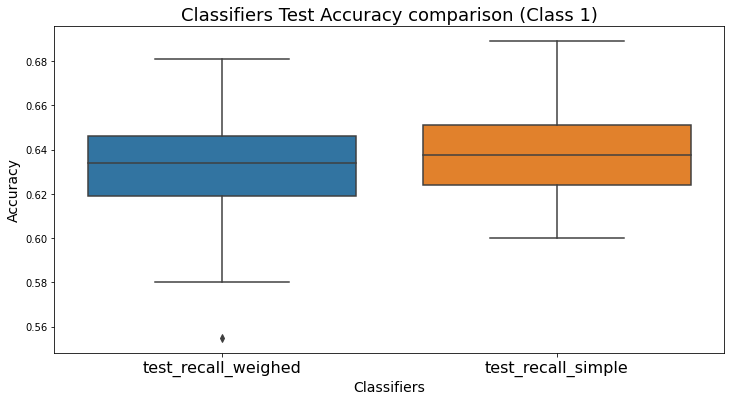

In [33]:
plt.subplots(figsize=(12,6))
sns.boxplot(data=test_recall)
plt.title('Classifiers Test Accuracy comparison (Class 1)',fontsize = 18)
plt.xlabel("Classifiers", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()

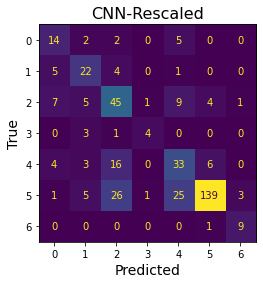

In [27]:
CM = sk.metrics.confusion_matrix(Y,Y_pred)
disp = sk.metrics.ConfusionMatrixDisplay(CM)
disp.plot()
disp.im_.colorbar.remove()
plt.title('CNN-Rescaled', fontsize = 16)
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('True', fontsize = 14)
plt.show()

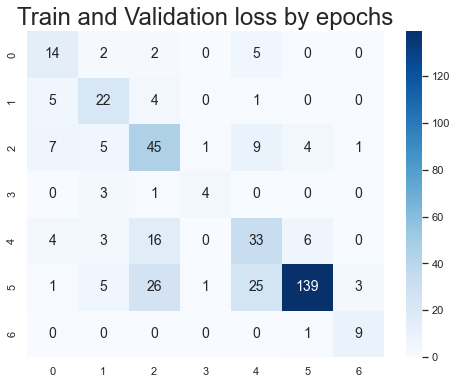

In [62]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sn.set(font_scale=1) # for label size
sn.heatmap(CM, annot=True, annot_kws={"size": 14},fmt= '' ,cmap='Blues') # font size
plt.title('Train and Validation loss by epochs', fontsize = 24)

plt.show()

# **CNN: AutoEncoder + 280x210**

In [ ]:
cols = ['image_id','CNN_0','CNN_1','CNN_2','CNN_3','CNN_4','CNN_5','CNN_6']
CNN_280x210_A_E = CNN_280x210_data_encoded_STD.merge(CNN_A_E_data_encoded_STD[cols],how='left',on='image_id')

In [17]:
pickle.dump(CNN_280x210_A_E, open(G_path + '/CNN_Output/'+ 'CNN_280x210_A_E_Output', 'wb'))

**Ordinal Encoding**

In [31]:
ord_enc = sk.preprocessing.OrdinalEncoder()
datasource_v3_Ord = datasource_v2
datasource_v3_Ord['sex'] = ord_enc.fit_transform(datasource_v3_Ord[['sex']])
datasource_v3_Ord['localization'] = ord_enc.fit_transform(datasource_v3_Ord[['localization']])
datasource_v3_Ord['dx_type'] = ord_enc.fit_transform(datasource_v3_Ord[['dx_type']])
datasource_v3_Ord.reset_index(drop=True, inplace=True)

In [29]:
def MinMaxScaling(dataset, attr):
    min = dataset[dataset.type.str.contains('train|valid')][attr].min()
    max = dataset[dataset.type.str.contains('train|valid')][attr].max()
    dataset[attr] = (dataset[attr] - min ) / (max-min)
    return dataset

In [36]:
datasource_v3_Ord_Norm = datasource_v3_Ord.copy()
datasource_v3_Ord_Norm = MinMaxScaling(datasource_v3_Ord_Norm , 'localization')
datasource_v3_Ord_Norm = MinMaxScaling(datasource_v3_Ord_Norm , 'dx_type')

In [ ]:
pd.to_pickle(datasource_v3_Ord, path+'DataSource_60x45_Ordinal_CNN.pickle' )